**Load all libraries**

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
import openpyxl
import requests
import datetime
import re
# Main source https://www.gov.uk/government/statistics/company-insolvencies-mmmm-yyyy

In [5]:
# Get most recent months data
current_month = datetime.datetime.now().strftime('%B-%Y').lower()
prior_month = (datetime.datetime.now() - datetime.timedelta(days=30)).strftime('%B-%Y').lower()
print(f'current_month: {current_month}')
print(f'prior_month: {prior_month}')

current_month: august-2025
prior_month: july-2025


In [6]:
url_current = f'https://www.gov.uk/government/statistics/company-insolvencies-{current_month}'
url_prior = f'https://www.gov.uk/government/statistics/company-insolvencies-{prior_month}'
response = None

try:
    os.makedirs('content')
except:
    pass

Main Extraction

In [28]:
# First, attempt to get the current month's URL.
print(f"Attempting to fetch current month URL: {url_current}")
try:
    response = requests.get(url_current)
    response.raise_for_status()  # This will raise an exception for 404, 500, etc.
    print('Current Month data found. Extracting...')

except requests.exceptions.RequestException as e:
    # If the current month request fails (e.g., a 404 Not Found error),
    # this block handles the fallback logic.
    print(f"Current month URL failed with an error: {e}")
    print(f"Attempting to fetch prior month URL: {url_prior}")

    try:
        response = requests.get(url_prior)
        response.raise_for_status()
        print("Prior month data found. Extracting...")
    except requests.exceptions.RequestException as e:
        # If the prior month request also fails, this block executes.
        print(f"Prior month URL also failed with an error: {e}")
        print("Could not retrieve data from either URL. Aborting.")
        response = None  # Ensure response is explicitly None

# --- Main Logic: Only run if a valid response was received ---
# This conditional check is the key to preventing the crash.
if response:
    # Use regular expressions to find the Excel link in the HTML content.
    # This is more robust than looking for a hard-coded string.
    # We are looking for any link that ends with '.xlsx'.
    excel_link = None
    # Compile a regular expression to find an href ending in .xlsx
    pattern = re.compile(r'href="([^"]+\.xlsx)"')

    # Search for the pattern in the response text
    match = pattern.search(response.text)
    if match:
        excel_link = match.group(1)

    if excel_link:
        # Construct the full URL if the link is relative.
        if not excel_link.startswith('http'):
            # The 'url' property of the response object gives us the base URL.
            excel_link = requests.compat.urljoin(response.url, excel_link)

        # Use the name of the file from the link itself for a dynamic file name.
        file_name = excel_link.split('/')[-1]

        # Download the Excel file
        try:
            excel_response = requests.get(excel_link)
            excel_response.raise_for_status()

            # Save the file. Use 'wb' for write binary mode.
            with open(f'content/{file_name}', 'wb') as f:
                f.write(excel_response.content)

            print(f"Downloaded '{file_name}' to /content/")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download the Excel file: {e}")
    else:
        print("Excel file link not found on the page.")

else:
    print("Skipping data processing as no valid response was retrieved.")


Attempting to fetch current month URL: https://www.gov.uk/government/statistics/company-insolvencies-august-2025


KeyboardInterrupt: 

In [ ]:
# file_name = 'Data_Tables_in_Excel__xlsx__Format_-_Company_Insolvency_Statistics_July_2025.xlsx' # placeholder for offline testing

Load required dataset


In [9]:
# print(f'{file_name}')
try:
  df = pd.read_excel(f'content/{file_name}')
  print('Data loaded')
  df.head(1)
except FileNotFoundError:
  print('File not found')
  exit()

Data loaded


In [11]:
sheet_to_extract = 'Table_1c'
df_single_sheet = pd.read_excel((f'content/{file_name}'), sheet_name=sheet_to_extract, skiprows=7)
df_single_sheet.head()

,Section,Division,Group,Description,2015,2016,2017,2018,2019,2020,...,Nov 2024,Dec 2024,Jan 2025,Feb 2025,Mar 2025,Apr 2025,May 2025,Jun 2025,Jul 2025,Notes
0,Total,-,-,-,14551.0,14669.0,14570.0,16051.0,17170.0,12630.0,...,2104.0,1783.0,1936.0,1878.0,2080.0,2058.0,2232.0,2079.0,[x],The following column(s) have been revised: 202...
1,A,NaN,NaN,"AGRICULTURE, FORESTRY AND FISHING",41.0,46.0,51.0,48.0,53.0,40.0,...,14.0,7.0,6.0,7.0,13.0,13.0,5.0,5.0,[x],NaN
2,A,01,NaN,"Crop and animal production, hunting and relate...",31.0,28.0,37.0,37.0,38.0,28.0,...,10.0,6.0,3.0,6.0,9.0,12.0,2.0,3.0,[x],NaN
3,A,01,011,Growing of non-perennial crops,6.0,6.0,6.0,9.0,3.0,4.0,...,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,[x],NaN
4,A,01,012,Growing of perennial crops,2.0,0.0,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,[x],NaN


In [12]:
header_row_index = 0
description_column_index = 0
is_all_caps = ~df_single_sheet['Description'].astype(str).str.contains('[a-z]', na=False)
is_not_total = ~df_single_sheet['Description'].astype(str).str.contains('[-]', na=False)

df_remove_lower_case = df_single_sheet[is_all_caps].copy()
df_filtered = df_remove_lower_case[is_not_total].copy()

df_filtered.drop(['Section','Division','Group','Notes'], axis=1, inplace=True)
df_filtered.head()

/var/folders/hg/0dhh61f52jx4x04lv_9gw_r80000gn/T/ipykernel_61871/4090048544.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered = df_remove_lower_case[is_not_total].copy()


,Description,2015,2016,2017,2018,2019,2020,2021,2022,2023,...,Oct 2024,Nov 2024,Dec 2024,Jan 2025,Feb 2025,Mar 2025,Apr 2025,May 2025,Jun 2025,Jul 2025
1,"AGRICULTURE, FORESTRY AND FISHING",41.0,46.0,51.0,48.0,53.0,40.0,38.0,85.0,84.0,...,13.0,14.0,7.0,6.0,7.0,13.0,13.0,5.0,5.0,[x]
18,MINING AND QUARRYING,35.0,54.0,29.0,29.0,26.0,20.0,38.0,39.0,37.0,...,2.0,1.0,3.0,1.0,2.0,3.0,1.0,2.0,2.0,[x]
34,MANUFACTURING,1446.0,1345.0,1289.0,1361.0,1482.0,1170.0,1018.0,1687.0,1993.0,...,155.0,166.0,152.0,172.0,163.0,171.0,153.0,181.0,173.0,[x]
154,"ELECTRICITY, GAS, STEAM AND AIR CONDITIONING S...",40.0,45.0,45.0,61.0,70.0,53.0,91.0,93.0,53.0,...,5.0,2.0,13.0,8.0,5.0,6.0,5.0,3.0,3.0,[x]
159,"WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R...",141.0,131.0,132.0,98.0,135.0,75.0,71.0,119.0,134.0,...,11.0,15.0,14.0,10.0,8.0,15.0,20.0,11.0,9.0,[x]


In [13]:
start_col_loc = df_filtered.columns.get_loc('Jan 2022')

# Find the last column that does NOT contain '[x]'
end_col_loc = start_col_loc
# Iterate backwards from the last column to the start column
for i in range(len(df_filtered.columns) - 1, start_col_loc - 1, -1):
    col_name = df_filtered.columns[i]
    # Check if any cell in the column contains the '[x]' marker
    if not df_filtered[col_name].astype(str).str.contains(r'\[x\]', regex=True).any():
        # If no '[x]' is found, this is our last valid column
        end_col_loc = i
        break
# Select the final columns
# Create a list of all column indices to keep:
# The description column + the range of valid data columns
cols_to_keep_indices = [description_column_index] + list(range(start_col_loc, end_col_loc + 1))
df_relevant_columns = df_filtered.iloc[:, cols_to_keep_indices]
df_relevant_columns.head()

,Description,Jan 2022,Feb 2022,Mar 2022,Apr 2022,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022,...,Sep 2024,Oct 2024,Nov 2024,Dec 2024,Jan 2025,Feb 2025,Mar 2025,Apr 2025,May 2025,Jun 2025
1,"AGRICULTURE, FORESTRY AND FISHING",2.0,2.0,7.0,6.0,5.0,11.0,8.0,12.0,5.0,...,5.0,13.0,14.0,7.0,6.0,7.0,13.0,13.0,5.0,5.0
18,MINING AND QUARRYING,6.0,1.0,6.0,2.0,2.0,4.0,4.0,8.0,2.0,...,2.0,2.0,1.0,3.0,1.0,2.0,3.0,1.0,2.0,2.0
34,MANUFACTURING,103.0,127.0,168.0,139.0,157.0,136.0,124.0,150.0,145.0,...,148.0,155.0,166.0,152.0,172.0,163.0,171.0,153.0,181.0,173.0
154,"ELECTRICITY, GAS, STEAM AND AIR CONDITIONING S...",11.0,8.0,13.0,16.0,1.0,8.0,7.0,6.0,8.0,...,6.0,5.0,2.0,13.0,8.0,5.0,6.0,5.0,3.0,3.0
159,"WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R...",4.0,8.0,12.0,11.0,12.0,12.0,5.0,12.0,11.0,...,12.0,11.0,15.0,14.0,10.0,8.0,15.0,20.0,11.0,9.0


In [14]:
print("Formatting and cleaning data...")
# Pivot to required format
df_formatted = pd.melt(df_relevant_columns, id_vars=['Description'], var_name='Date', value_name='Value')
# Clean columns
df_formatted['Value'] = df_formatted['Value'].astype(str).str.replace(',', '', regex=False)
df_formatted['Value'] = pd.to_numeric(df_formatted['Value'], errors='coerce')
# Remove NA values
df_formatted.dropna(subset=['Value'], inplace=True)

# Change Description column to Category
df_formatted['Date'] = pd.to_datetime(df_formatted['Date'], format='%b %Y')
df_formatted.rename(columns={'Description': 'Category'}, inplace=True)

# Rename a long category name
long_name = 'ACTIVITIES OF HOUSEHOLDS AS EMPLOYERS; UNDIFFERENTIATED GOODS-AND SERVICES-PRODUCING ACTIVITIES OF HOUSEHOLDS FOR OWN USE'
short_name = 'UNDIFFERENTIATED G&S PRODUCING ACTIVITIES OF HOUSEHOLDS FOR OWN USE'
df_formatted['Category'] = df_formatted['Category'].replace(long_name, short_name)

df_formatted.head()

Formatting and cleaning data...


,Category,Date,Value
0,"AGRICULTURE, FORESTRY AND FISHING",2022-01-01,2.0
1,MINING AND QUARRYING,2022-01-01,6.0
2,MANUFACTURING,2022-01-01,103.0
3,"ELECTRICITY, GAS, STEAM AND AIR CONDITIONING S...",2022-01-01,11.0
4,"WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND R...",2022-01-01,4.0


In [15]:
pivot_df = df_formatted.pivot_table(
    index=df_formatted['Date'].dt.to_period('M'),
    columns='Category',
    values='Value',
    aggfunc='sum',
    fill_value=0
)
pivot_df.head()

Category,ACCOMMODATION AND FOOD SERVICE ACTIVITIES,ACTIVITIES OF EXTRATERRITORIAL ORGANISATIONS AND BODIES,ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES,"AGRICULTURE, FORESTRY AND FISHING",ALL OTHERS,"ARTS, ENTERTAINMENT AND RECREATION",CONSTRUCTION,EDUCATION,"ELECTRICITY, GAS, STEAM AND AIR CONDITIONING SUPPLY",FINANCIAL AND INSURANCE ACTIVITIES,...,INFORMATION AND COMMUNICATION,MANUFACTURING,MINING AND QUARRYING,OTHER SERVICE ACTIVITIES,"PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES",PUBLIC ADMINISTRATION AND DEFENCE; COMPULSORY SOCIAL SECURITY,REAL ESTATE ACTIVITIES,TRANSPORTATION AND STORAGE,"WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND REMEDIATION ACTIVITIES",WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES
Date,,,,,,,,,,,,,,,,,,,,,
2022-01,187.0,0.0,165.0,2.0,19.0,27.0,318.0,32.0,11.0,31.0,...,94.0,103.0,6.0,89.0,144.0,2.0,40.0,44.0,4.0,218.0
2022-02,175.0,0.0,167.0,2.0,17.0,45.0,309.0,12.0,8.0,24.0,...,82.0,127.0,1.0,74.0,121.0,2.0,65.0,69.0,8.0,176.0
2022-03,238.0,1.0,208.0,7.0,20.0,30.0,421.0,20.0,13.0,39.0,...,144.0,168.0,6.0,109.0,185.0,2.0,76.0,70.0,12.0,313.0
2022-04,217.0,0.0,202.0,6.0,32.0,38.0,382.0,23.0,16.0,31.0,...,120.0,139.0,2.0,124.0,170.0,3.0,58.0,78.0,11.0,288.0
2022-05,224.0,0.0,180.0,5.0,16.0,32.0,352.0,21.0,1.0,30.0,...,109.0,157.0,2.0,100.0,160.0,3.0,53.0,65.0,12.0,265.0


In [16]:
df_formatted['Year'] = df_formatted['Date'].dt.year

yearly_pivot_df = df_formatted.pivot_table(
    index='Year',
    columns='Category',
    values='Value',
    aggfunc='sum',
    fill_value=0
)
yearly_pivot_df.head()

Category,ACCOMMODATION AND FOOD SERVICE ACTIVITIES,ACTIVITIES OF EXTRATERRITORIAL ORGANISATIONS AND BODIES,ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES,"AGRICULTURE, FORESTRY AND FISHING",ALL OTHERS,"ARTS, ENTERTAINMENT AND RECREATION",CONSTRUCTION,EDUCATION,"ELECTRICITY, GAS, STEAM AND AIR CONDITIONING SUPPLY",FINANCIAL AND INSURANCE ACTIVITIES,...,INFORMATION AND COMMUNICATION,MANUFACTURING,MINING AND QUARRYING,OTHER SERVICE ACTIVITIES,"PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES",PUBLIC ADMINISTRATION AND DEFENCE; COMPULSORY SOCIAL SECURITY,REAL ESTATE ACTIVITIES,TRANSPORTATION AND STORAGE,"WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND REMEDIATION ACTIVITIES",WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES
Year,,,,,,,,,,,,,,,,,,,,,
2022,2711.0,3.0,2214.0,85.0,248.0,432.0,4168.0,270.0,93.0,414.0,...,1289.0,1687.0,39.0,1262.0,1807.0,32.0,720.0,785.0,119.0,3283.0
2023,3738.0,4.0,2306.0,84.0,330.0,478.0,4389.0,314.0,53.0,420.0,...,1396.0,1993.0,37.0,1350.0,2013.0,23.0,750.0,881.0,134.0,3948.0
2024,3466.0,0.0,2371.0,97.0,274.0,425.0,4037.0,265.0,61.0,504.0,...,1510.0,1930.0,27.0,1135.0,1917.0,24.0,734.0,861.0,141.0,3577.0
2025,1706.0,0.0,1292.0,49.0,168.0,213.0,2087.0,123.0,30.0,243.0,...,724.0,1013.0,11.0,553.0,982.0,11.0,397.0,385.0,73.0,1914.0


# **Experimental Section**

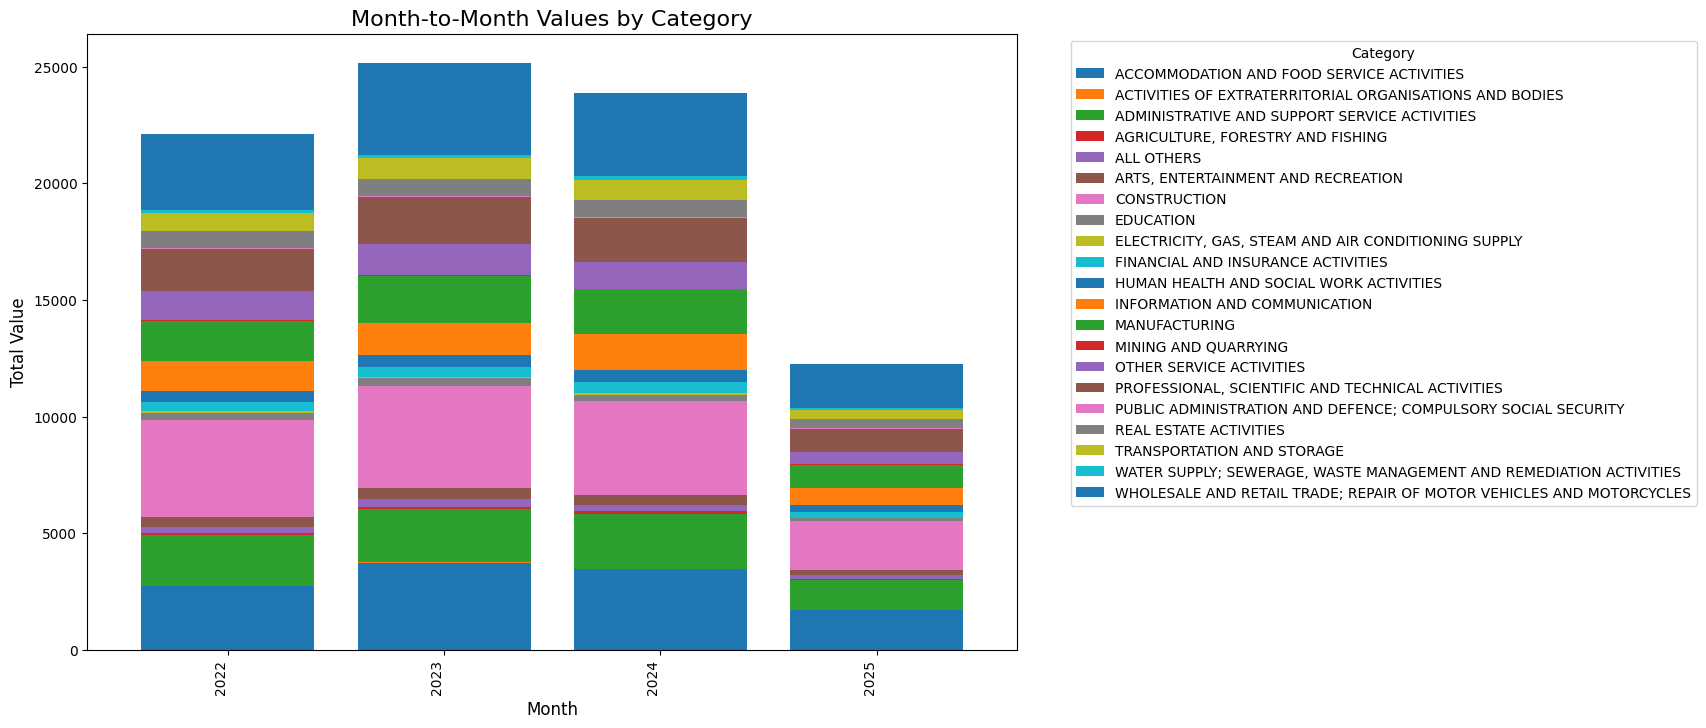

In [17]:
# @title Annual Grouping

# Create the stacked bar chart from the pivoted data
# ax = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), width=0.8)
ax = yearly_pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), width=0.8)

# Customize the plot for better readability
ax.set_title('Month-to-Month Values by Category', fontsize=16)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Total Value', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the chart
plt.show()

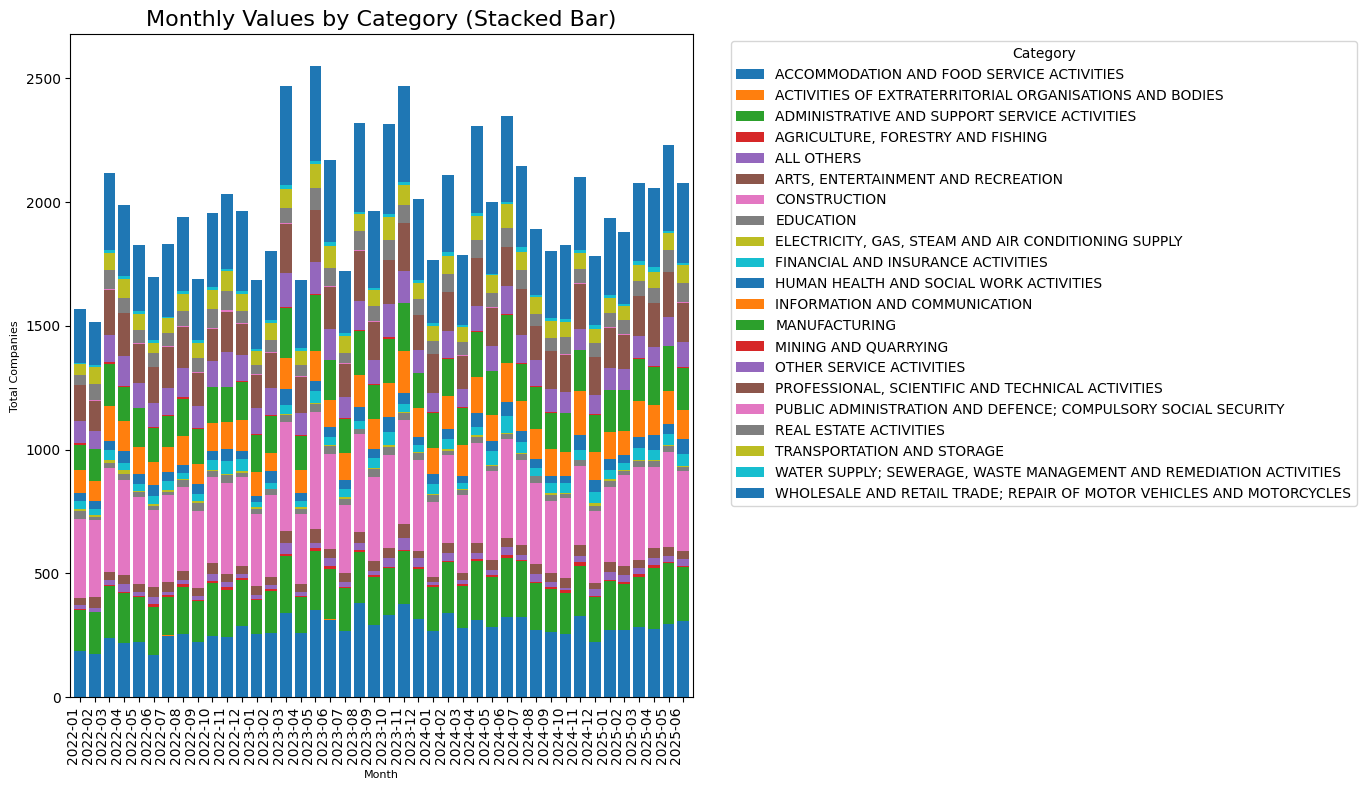

In [18]:
# @title Monthly Grouping
ax_bar = pivot_df.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    width=0.8  # Makes bars wider and reduces the gap. Default is 0.5.
)

ax_bar.set_title('Monthly Values by Category (Stacked Bar)', fontsize=16)
ax_bar.set_xlabel('Month', fontsize=8)
ax_bar.set_ylabel('Total Companies', fontsize=8)
plt.xticks(rotation=90, ha='right')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
# @title Categrories
# ----> IMPORTANT: Choose which categories you want to plot here <----
# You can see all available categories by uncommenting the line below:
import pprint
# print(f"Available categories: {pivot_df.columns.tolist()}")
pprint.pp(pivot_df.columns.tolist())

['ACCOMMODATION AND FOOD SERVICE ACTIVITIES',
 'ACTIVITIES OF EXTRATERRITORIAL ORGANISATIONS AND BODIES',
 'ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES',
 'AGRICULTURE, FORESTRY AND FISHING',
 'ALL OTHERS',
 'ARTS, ENTERTAINMENT AND RECREATION',
 'CONSTRUCTION',
 'EDUCATION',
 'ELECTRICITY, GAS, STEAM AND AIR CONDITIONING SUPPLY',
 'FINANCIAL AND INSURANCE ACTIVITIES',
 'HUMAN HEALTH AND SOCIAL WORK ACTIVITIES',
 'INFORMATION AND COMMUNICATION',
 'MANUFACTURING',
 'MINING AND QUARRYING',
 'OTHER SERVICE ACTIVITIES',
 'PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES',
 'PUBLIC ADMINISTRATION AND DEFENCE; COMPULSORY SOCIAL SECURITY',
 'REAL ESTATE ACTIVITIES',
 'TRANSPORTATION AND STORAGE',
 'WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND REMEDIATION ACTIVITIES',
 'WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES']


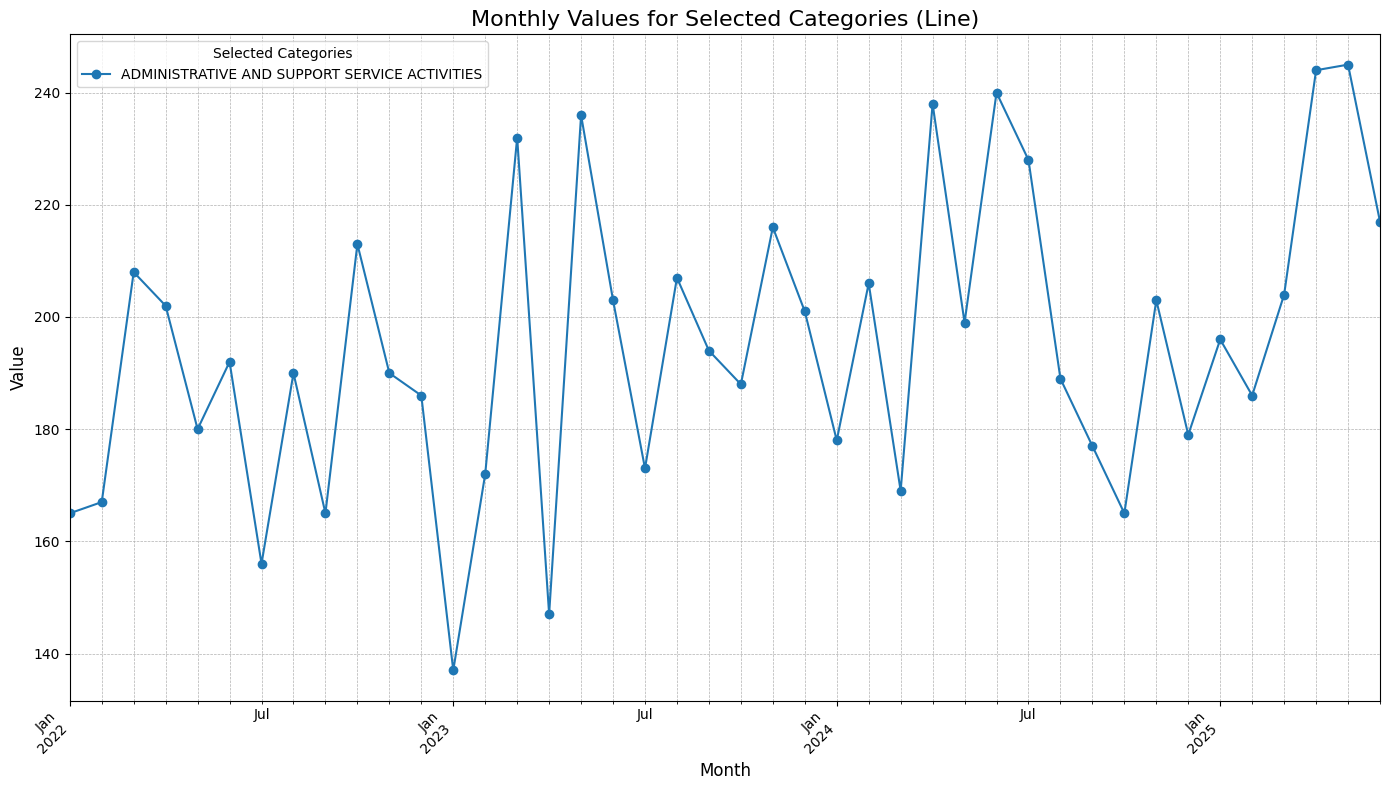

In [20]:
# @title Line graph of selected categories
selected_categories = pivot_df.columns.tolist()

selected_categories = [
    'ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES',
    # 'CONSTRUCTION',
    # 'WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES',
    # 'CONSTRUCTION' # Add or remove categories from this list
]

# Filter the DataFrame to only include the columns (categories) you selected
# This check ensures that the categories exist before trying to plot them
# valid_categories = [cat for cat in selected_categories if cat in pivot_df.columns]
valid_categories = [cat for cat in selected_categories if cat in pivot_df.columns]

if not valid_categories:
    print("Warning: None of the selected categories were found in the data. Skipping line graph.")
else:
    ax_line = pivot_df[valid_categories].plot(
        kind='line',
        figsize=(14, 8),
        marker='o'  # Adds circles to data points for better visibility
    )

    ax_line.set_title('Monthly Values for Selected Categories (Line)', fontsize=16)
    ax_line.set_xlabel('Month', fontsize=12)
    ax_line.set_ylabel('Value', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend(title='Selected Categories')
    plt.tight_layout()
    plt.show()


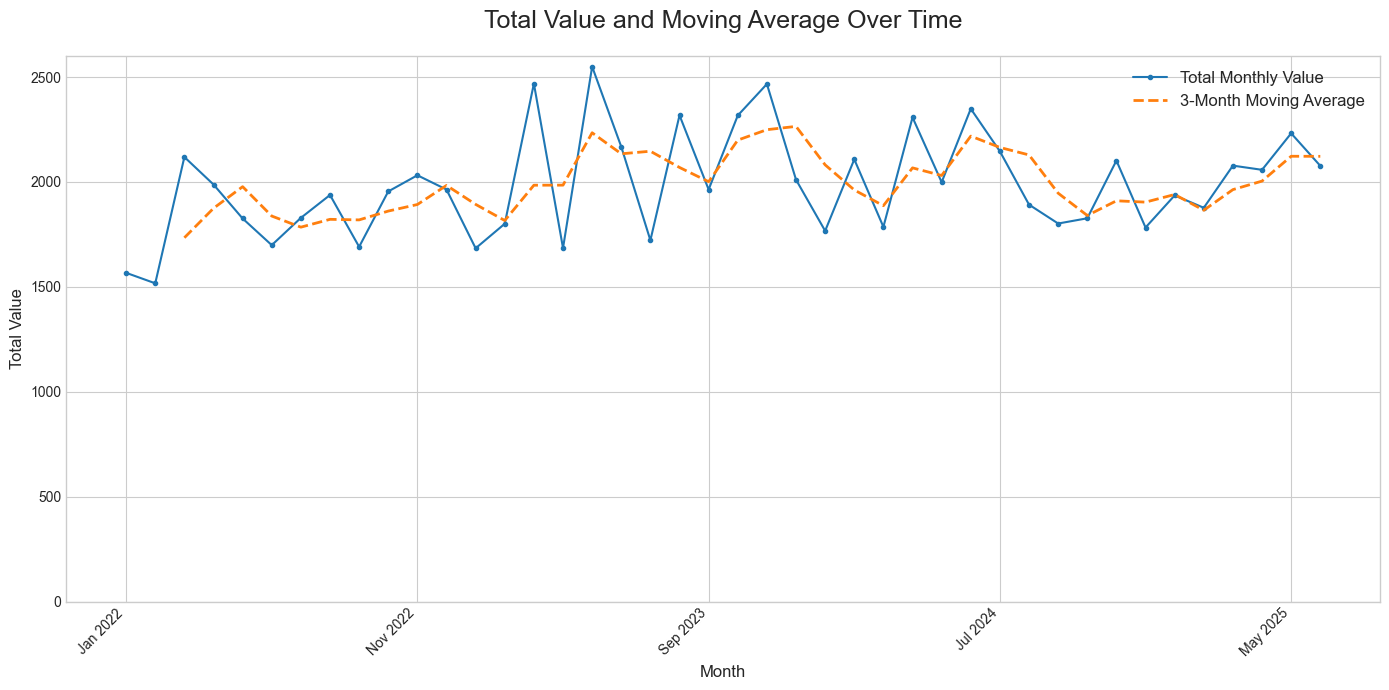

In [22]:
# @title 3 Month Moving Average Graph

import pandas as pd
import matplotlib.pyplot as plt

monthly_totals = df_formatted.groupby(df_formatted['Date'].dt.to_period('M'))['Value'].sum()

WINDOW_SIZE = 3

# Check if there is enough data
if len(monthly_totals) < WINDOW_SIZE:
    print(f"**Warning:** You have only {len(monthly_totals)} months of data. "
          f"A {WINDOW_SIZE}-month moving average requires at least {WINDOW_SIZE} months to produce a single value and more show a trend.")

moving_average = monthly_totals.rolling(window=WINDOW_SIZE).mean()

# Prepare data with string index for stable plotting
plot_df = pd.DataFrame({
    'Total Value': monthly_totals,
    'Moving Average': moving_average
})
# Set the index to your desired string format ('Jan 2022')
plot_df.index = plot_df.index.strftime('%b %Y')


# Step 3: Plot the DataFrame with the corrected string index
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7))

plot_df['Total Value'].plot(ax=ax, label='Total Monthly Value', marker='.', linestyle='-')
plot_df['Moving Average'].plot(ax=ax, label=f'{WINDOW_SIZE}-Month Moving Average', linestyle='--', linewidth=2)

# Formatting the plot
ax.set_title('Total Value and Moving Average Over Time', fontsize=18, pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Total Value', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate the labels
ax.legend(fontsize=12)
fig.tight_layout()
ax.set_ylim(bottom=0)

plt.show()



--- Generating Category Growth Analysis ---
Category with HIGHEST growth trend: 'ACCOMMODATION AND FOOD SERVICE ACTIVITIES'
Category with LOWEST growth trend: 'OTHER SERVICE ACTIVITIES'


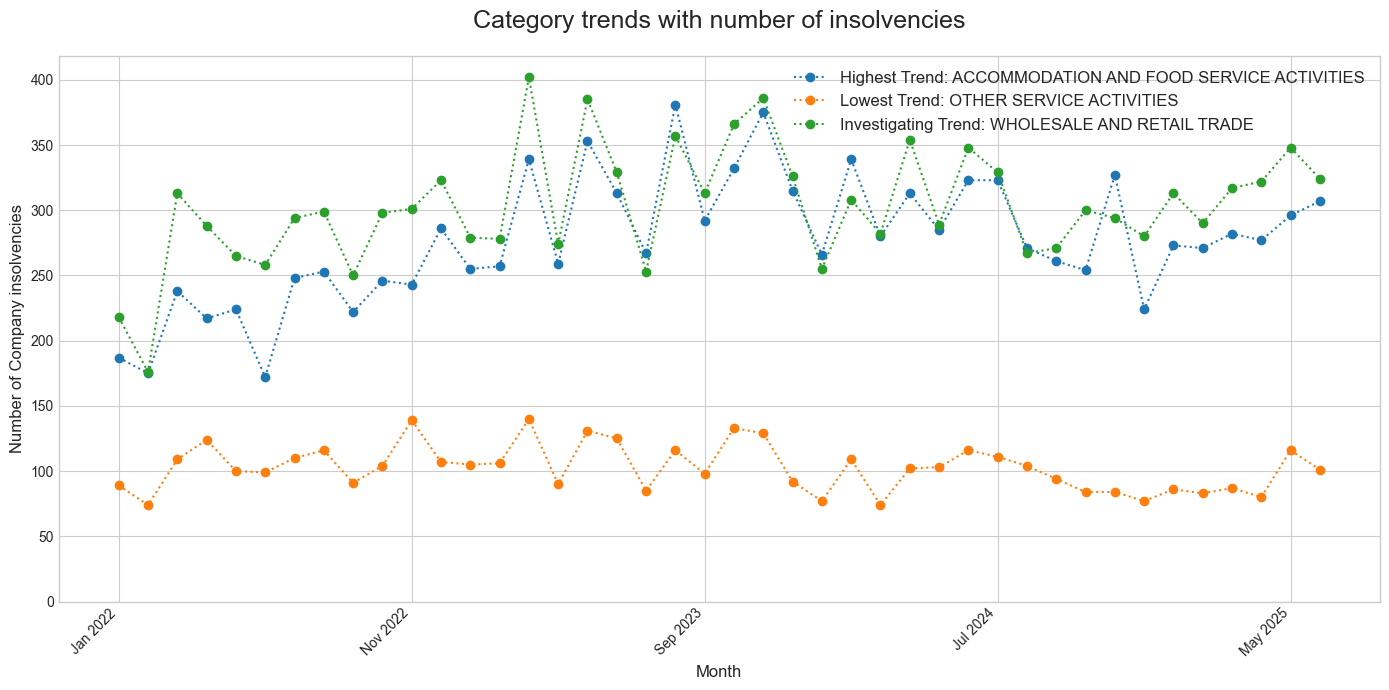

In [23]:
# @title Category Changes over time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume 'df_formatted' is your DataFrame

print("\n--- Generating Category Growth Analysis ---")

pivot_df = df_formatted.pivot_table(
    index=df_formatted['Date'].dt.to_period('M'),
    columns='Category',
    values='Value',
    aggfunc='sum',
    fill_value=0
)

slopes = {}
x_axis = np.arange(len(pivot_df.index))
for category in pivot_df.columns:
    slope, _ = np.polyfit(x_axis, pivot_df[category], 1)
    slopes[category] = slope

slopes_series = pd.Series(slopes)
highest_growth_cat = slopes_series.idxmax()
lowest_growth_cat = slopes_series.idxmin()

print(f"Category with HIGHEST growth trend: '{highest_growth_cat}'")
print(f"Category with LOWEST growth trend: '{lowest_growth_cat}'")

# --- FIX: Prepare data with string index for stable plotting ---
plot_pivot_df = pivot_df.copy()
plot_pivot_df.index = plot_pivot_df.index.strftime('%b %Y')


# Step 3: Plot the DataFrame with the corrected string index
fig, ax = plt.subplots(figsize=(14, 7))

plot_pivot_df[highest_growth_cat].plot(ax=ax, label=f'Highest Trend: {highest_growth_cat}', marker='o', linestyle=':')
plot_pivot_df[lowest_growth_cat].plot(ax=ax, label=f'Lowest Trend: {lowest_growth_cat}', marker='o', linestyle=':')
plot_pivot_df['WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES'].plot(ax=ax, label=f'Investigating Trend: WHOLESALE AND RETAIL TRADE', marker='o', linestyle=':')
# plot_pivot_df['ACTIVITIES OF EXTRATERRITORIAL ORGANISATIONS AND BODIES'].plot(ax=ax, label=f'Investigating Trend: WHOLESALE AND RETAIL TRADE', marker='o', linestyle=':')

# Formatting the plot
ax.set_title('Category trends with number of insolvencies', fontsize=18, pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Company insolvencies', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate the labels
ax.legend(fontsize=12)
ax.set_ylim(bottom=0)
fig.tight_layout()
plt.show()


In [24]:
# @title Volatility by industry
volatility = (pivot_df.std() / pivot_df.mean()) * 100

print("\n--- Volatility Score (Coefficient of Variation %) ---")
# A higher score means more volatility and less predictability
print(volatility.sort_values(ascending=False))


--- Volatility Score (Coefficient of Variation %) ---
Category
ACTIVITIES OF EXTRATERRITORIAL ORGANISATIONS AND BODIES                 226.317282
MINING AND QUARRYING                                                     64.218733
PUBLIC ADMINISTRATION AND DEFENCE; COMPULSORY SOCIAL SECURITY            63.176957
ELECTRICITY, GAS, STEAM AND AIR CONDITIONING SUPPLY                      57.367089
AGRICULTURE, FORESTRY AND FISHING                                        46.398766
ALL OTHERS                                                               34.116410
WATER SUPPLY; SEWERAGE, WASTE MANAGEMENT AND REMEDIATION ACTIVITIES      31.230706
FINANCIAL AND INSURANCE ACTIVITIES                                       26.198934
EDUCATION                                                                24.639361
HUMAN HEALTH AND SOCIAL WORK ACTIVITIES                                  24.366175
REAL ESTATE ACTIVITIES                                                   20.068477
ARTS, ENTERTAINMENT AND

In [25]:
slopes_series

ACCOMMODATION AND FOOD SERVICE ACTIVITIES                               1.868001
ACTIVITIES OF EXTRATERRITORIAL ORGANISATIONS AND BODIES                -0.008670
ADMINISTRATIVE AND SUPPORT SERVICE ACTIVITIES                           0.814926
AGRICULTURE, FORESTRY AND FISHING                                       0.051941
ALL OTHERS                                                              0.167572
ARTS, ENTERTAINMENT AND RECREATION                                     -0.017503
CONSTRUCTION                                                           -0.275423
EDUCATION                                                              -0.040029
ELECTRICITY, GAS, STEAM AND AIR CONDITIONING SUPPLY                    -0.088405
FINANCIAL AND INSURANCE ACTIVITIES                                      0.309456
HUMAN HEALTH AND SOCIAL WORK ACTIVITIES                                 0.220241
INFORMATION AND COMMUNICATION                                           0.650271
MANUFACTURING               

--- Comparing Year-to-Date performance (up to month 6) ---


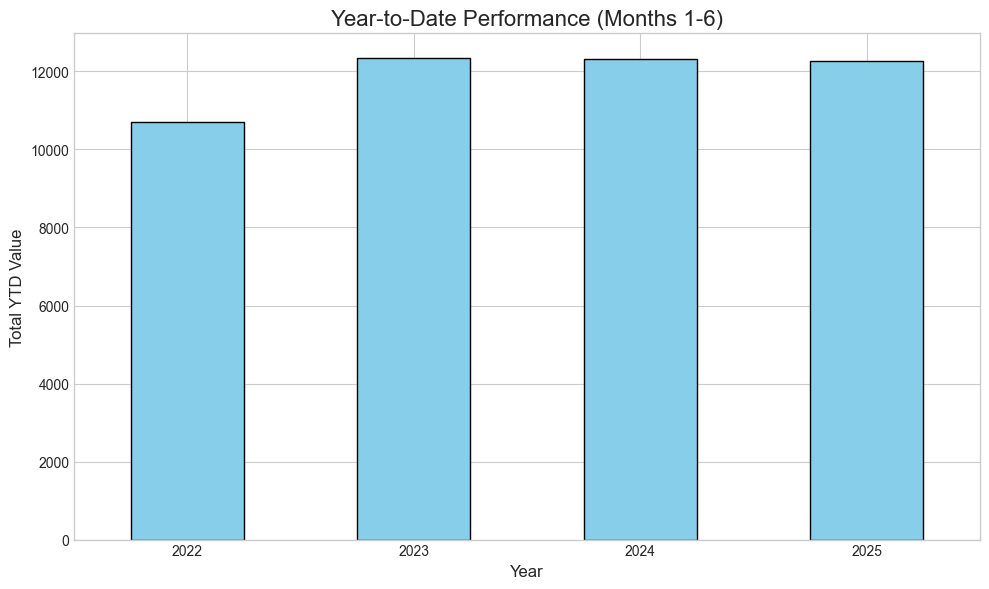

In [26]:

# @title Year-to-Date (YTD) Analysis

# Find the latest month in your data
# latest_month = df_formatted['Date'].dt.month.max()
latest_year = df_formatted['Date'].dt.year.max()
latest_month = df_formatted[df_formatted['Date'].dt.year == latest_year]['Date'].dt.month.max()


print(f"--- Comparing Year-to-Date performance (up to month {latest_month}) ---")

# Filter the DataFrame to only include data up to that month for all years
ytd_df = df_formatted[df_formatted['Date'].dt.month <= latest_month].copy()

# Create a 'Year' column
ytd_df['Year'] = ytd_df['Date'].dt.year

# Group by year and sum the values for the YTD period
ytd_totals = ytd_df.groupby('Year')['Value'].sum()

# --- Plotting the YTD Comparison ---
fig, ax = plt.subplots(figsize=(10, 6))
ytd_totals.plot(
    kind='bar',
    ax=ax,
    color='skyblue',
    edgecolor='black'
)

ax.set_title(f'Year-to-Date Performance (Months 1-{latest_month})', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Total YTD Value', fontsize=12)
plt.xticks(rotation=0)
ax.set_ylim(bottom=0)
fig.tight_layout()
plt.show()


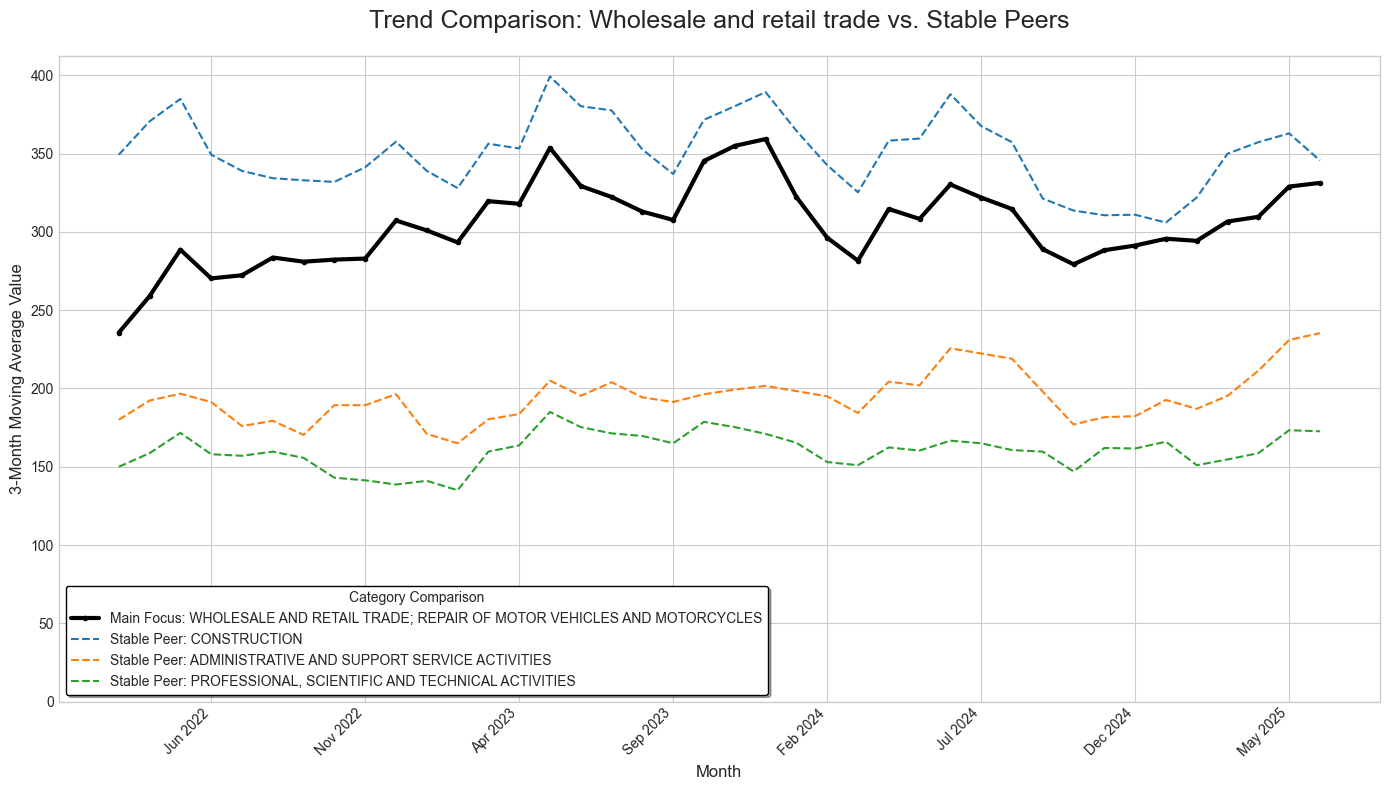

In [27]:
# @title Single category vs peers

CHOSEN_CATEGORY = 'WHOLESALE AND RETAIL TRADE; REPAIR OF MOTOR VEHICLES AND MOTORCYCLES'

# How many other stable categories you want to compare against
NUM_SIMILAR_CATEGORIES = 3
# The window for the moving average
WINDOW_SIZE = 3


# Find the Most Stable Categories
# First, we need to pivot the data to analyze each category's time series
pivot_df = df_formatted.pivot_table(
    index=df_formatted['Date'].dt.to_period('M'),
    columns='Category',
    values='Value',
    aggfunc='sum',
    fill_value=0
)

# Calculate volatility (a lower score is more stable)
volatility = (pivot_df.std() / pivot_df.mean()) * 100
# Sort by volatility to get a ranked list of the most stable categories
stable_categories = volatility.sort_values(ascending=True)


#Select Categories and Calculate Moving Averages
if CHOSEN_CATEGORY not in pivot_df.columns:
    print(f"Error: Category '{CHOSEN_CATEGORY}' was not found in the data.")
else:
    # Get the top N most stable categories, excluding the one we already chose
    similar_cats_to_plot = stable_categories[stable_categories.index != CHOSEN_CATEGORY].head(NUM_SIMILAR_CATEGORIES).index.tolist()

    # Calculate the moving average for all categories
    moving_averages_df = pivot_df.rolling(window=WINDOW_SIZE).mean()

    # Prepare a DataFrame for plotting with a clean string index
    plot_df = moving_averages_df.copy()
    plot_df.index = plot_df.index.strftime('%b %Y')

    # --- 4. Plotting the Comparison ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the CHOSEN_CATEGORY with a distinct, solid line
    plot_df[CHOSEN_CATEGORY].plot(
        ax=ax,
        label=f'Main Focus: {CHOSEN_CATEGORY}',
        linewidth=3,
        color='black',
        marker='.'
    )

    # Plot the other stable categories with lighter, dashed lines
    for cat in similar_cats_to_plot:
        plot_df[cat].plot(
            ax=ax,
            label=f'Stable Peer: {cat}',
            linestyle='--',
            linewidth=1.5
        )

    # Formatting the plot
    ax.set_title(f'Trend Comparison: Wholesale and retail trade vs. Stable Peers', fontsize=18, pad=20)
    ax.set_xlabel('Month', fontsize=12)
    ax.set_ylabel(f'{WINDOW_SIZE}-Month Moving Average Value', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    ax.legend(title='Category Comparison')
    ax.set_ylim(bottom=0)
    fig.tight_layout()
    ax.legend(
        title='Category Comparison',
        frameon=True,
        facecolor='white',
        edgecolor='black',
        shadow=True,
        fancybox=True
   )
    plt.show()